## AR모델은 자기회귀 모델로 자기 상관성을 시계열 모델로 구성한 것.
## AR(1): 바로 전시점이다. y=C+x+e

In [1]:
import FinanceDataReader as fdr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pmdarima.arima import ndiffs # 차분라이브러리
import pmdarima as pm

In [2]:
df_krx=fdr.StockListing('KRX')

In [3]:
symbol=df_krx[df_krx['Name']=='삼성전자']['Symbol']

In [4]:
df_samsung=fdr.DataReader('005930'.join(symbol.values),'20200101', '20211231')

In [5]:
df_samsung

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2020-01-02,55500,56000,55000,55200,12993228,-0.010753
2020-01-03,56000,56600,54900,55500,15422255,0.005435
2020-01-06,54900,55600,54600,55500,10278951,0.000000
2020-01-07,55700,56400,55600,55800,10009778,0.005405
2020-01-08,56200,57400,55900,56800,23501171,0.017921
...,...,...,...,...,...,...
2021-12-24,80200,80800,80200,80500,12086380,0.007509
2021-12-27,80600,80600,79800,80200,10783368,-0.003727
2021-12-28,80200,80400,79700,80300,18226325,0.001247


In [6]:
df_samsung_cl=df_samsung['Close']

In [7]:
df_samsung_cl

Date
2020-01-02    55200
2020-01-03    55500
2020-01-06    55500
2020-01-07    55800
2020-01-08    56800
              ...  
2021-12-24    80500
2021-12-27    80200
2021-12-28    80300
2021-12-29    78800
2021-12-30    78300
Name: Close, Length: 496, dtype: int64

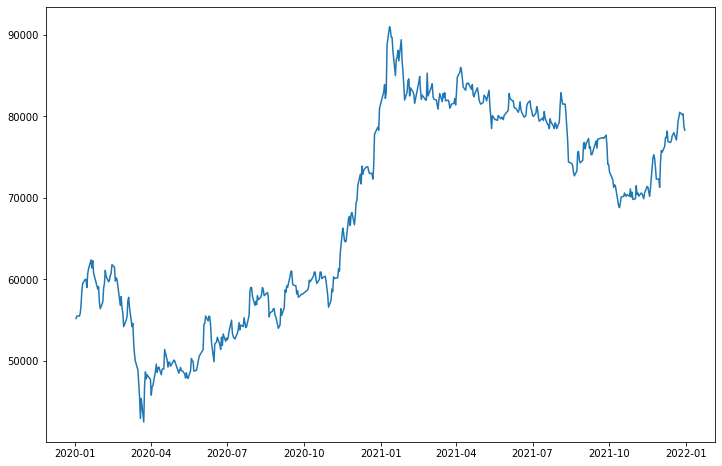

In [8]:
plt.figure(figsize=(12,8))

plt.plot(df_samsung_cl)



plt.show()

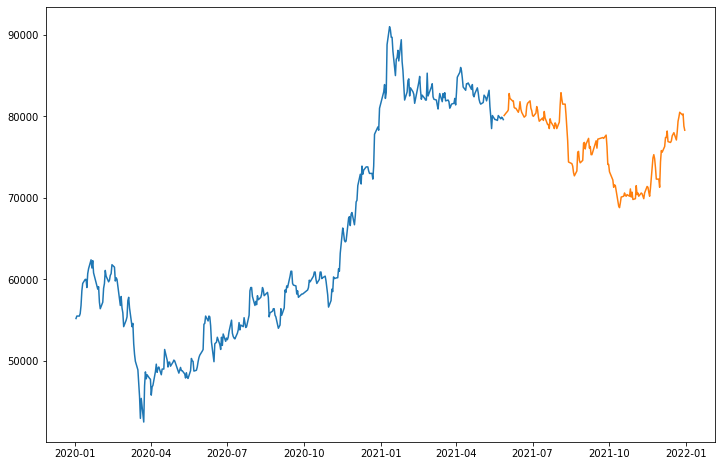

In [9]:
y_train=df_samsung['Close'][:int(0.7*len(df_samsung))]
y_test=df_samsung['Close'][int(0.7*len(df_samsung)):]

plt.figure(figsize=(12,8))

plt.plot(y_train)
plt.plot(y_test)



In [10]:
# ndiffs 차분 차수 찾기 #최적의 차분값을 찾아주는 거
kpss_difss=ndiffs(y_train,alpha=0.05,test='kpss',max_d=6)
adf_difss=ndiffs(y_train,alpha=0.05,test='adf',max_d=6)
n_diffs=max(kpss_difss,adf_difss)

print(f'적정 차분차수 {n_diffs}')

적정 차분차수 1


In [11]:
model=pm.auto_arima(y=y_train,
              d=1,
              start_p=0,
              max_p=3,
              start_q=0,
            max_q=3,
               seasonal=False,
               stepwise=True,
               trace=True)# stepwise 옵티마 찾는 역할 # AIC가 가장 작은것을 선택해야함


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5890.906, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5892.850, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5892.866, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5890.105, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=5894.864, Time=0.16 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.284 seconds


In [12]:
model.fit(y_train)


ARIMA(order=(0, 1, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [13]:
y_predict=model.predict(n_periods=len(y_test))

y_predict=pd.DataFrame(y_predict,index=y_test.index, columns=['Prediction'])
y_predict

,Prediction
Date,
2021-05-28,79600.0
2021-05-31,79600.0
2021-06-01,79600.0
2021-06-02,79600.0
2021-06-03,79600.0
...,...
2021-12-24,79600.0
2021-12-27,79600.0
2021-12-28,79600.0


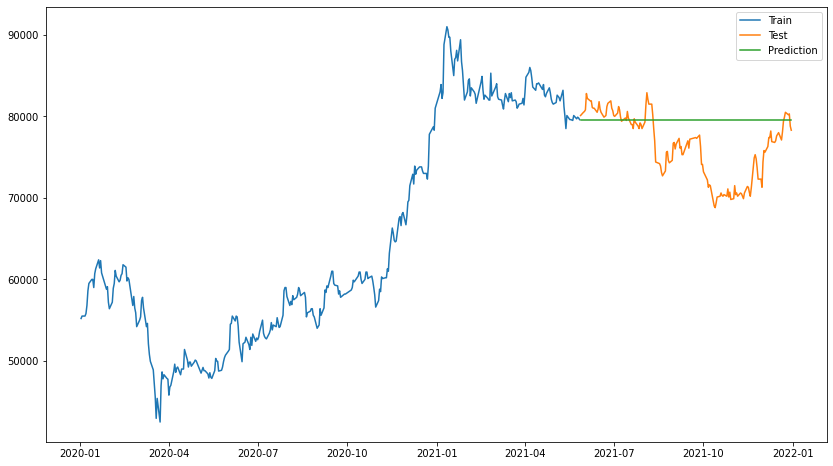

In [14]:
fig,ax=plt.subplots(figsize=(14,8))
plt.plot(y_train,label='Train')
plt.plot(y_test,label='Test')
plt.plot(y_predict,label='Prediction')
plt.legend()
plt.show() # 너무 길게 잡아서 생긴 모양


In [15]:
def forcast_one_step(): # y_test를 포문으로 돌릴려고 한 스텝씩 밟음 
    fc, conf_int= model.predict(n_periods=1,return_conf_int=True) # 그전에꺼 
    
    return (fc.tolist()[0], np.asanyarray(conf_int).tolist()[0]) # 숫자만 뽑아냄



In [16]:
forcast_one_step()

(79600.0, [77251.89428339618, 81948.10571660382])

In [17]:
forcast_list=[]
y_pred=[]
pred_upper=[]
pred_lower=[]

for i in y_test:
    fc,conf=forcast_one_step()
    y_pred.append(fc)
    pred_upper.append(conf[1])
    pred_lower.append(conf[0])
    
    model.update(i)


In [18]:
y_pred

[79600.0,
 80100.0,
 80500.0,
 80600.0,
 80800.0,
 82800.0,
 82200.0,
 81900.0,
 81900.0,
 81100.0,
 81000.0,
 81000.0,
 80500.0,
 80900.0,
 81800.0,
 80900.0,
 80500.0,
 79900.0,
 80000.0,
 80100.0,
 81200.0,
 81600.0,
 81900.0,
 81000.0,
 80700.0,
 80100.0,
 80000.0,
 80400.0,
 81200.0,
 80800.0,
 79900.0,
 79400.0,
 79700.0,
 79800.0,
 79500.0,
 80600.0,
 79800.0,
 79000.0,
 79000.0,
 78500.0,
 79700.0,
 79300.0,
 78800.0,
 78500.0,
 79200.0,
 79000.0,
 78500.0,
 79300.0,
 81400.0,
 82900.0,
 82100.0,
 81500.0,
 81500.0,
 80200.0,
 78500.0,
 77000.0,
 74400.0,
 74200.0,
 73900.0,
 73100.0,
 72700.0,
 73300.0,
 75600.0,
 75700.0,
 74600.0,
 74300.0,
 74600.0,
 76700.0,
 76800.0,
 76000.0,
 76600.0,
 77300.0,
 76100.0,
 76300.0,
 75300.0,
 75300.0,
 76300.0,
 76600.0,
 77000.0,
 76100.0,
 77200.0,
 77400.0,
 77300.0,
 77700.0,
 76300.0,
 74100.0,
 74100.0,
 73200.0,
 72200.0,
 71300.0,
 71600.0,
 71500.0,
 69000.0,
 68800.0,
 69400.0,
 70100.0,
 70200.0,
 70600.0,
 70300.0,
 70200.0,


In [19]:
pd.DataFrame({'test':y_test,'pred':y_pred})

,test,pred
Date,,
2021-05-28,80100,79600.0
2021-05-31,80500,80100.0
2021-06-01,80600,80500.0
2021-06-02,80800,80600.0
2021-06-03,82800,80800.0
...,...,...
2021-12-24,80500,79900.0
2021-12-27,80200,80500.0
2021-12-28,80300,80200.0


In [30]:
import plotly.graph_objects as go # 효과적으로 시각화하는 라이브러리
# import plotly.io as pio
# pio.renderers.default = "notebook_connect-*/-sdds2                          90`ed"

In [29]:

import plotly.graph_objects as go

fig = go.Figure([
    # 훈련 데이터 -----------------------------------------------
go.Scatter(x= y_train.index, y= y_train, name ="train", mode="lines", line=dict(color='royalblue'))
, # 테스트 데이터 ----------------------------------------------6-
go.Scatter(x= y_test.index, y= y_test, name ="Test", mode="lines", line=dict(color='rgba(0,0,30,0.5)')),
 # 예측값 -----------------------------------------------
go.Scatter(x= y_test.index, y= y_pred, name ="Prediction", mode="lines", line=dict(color='red', dash='dot', width=3)),
 # 신뢰구간-----------------------------------------------
go.Scatter(x= y_test.index.tolist() + y_test.index[::-1].tolist(),
           y = pred_upper+pred_lower[::-1],
           fill='toself',
           fillcolor='rgba(0,0,30,0.1)',
           line=dict(color='rgba(0,0,0,0)'),
           hoverinfo="skip", # 마우스 가져다대면 생기는 것
           showlegend=False)])
fig.update_layout(height=400, width=1000, title_text ="ARIMA(0,1,0)모형")
fig.show()